 # Phase 1: Static ASL Alphabet Classification

 **DAEN 429 Course Project - Sign Language Recognition**



 This script implements transfer learning with ResNet-18 for ASL alphabet classification.

 Four training configurations are compared:

 - **T-A**: Head-only fine-tuning

 - **T-B**: Last block (layer4 + head)

 - **T-C**: Progressive (layer3 + layer4 + head from T-B checkpoint)

 - **S-A**: Training from scratch

 ## 1. Setup & Imports

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
import torchvision
from torchvision import datasets, transforms, models
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from pathlib import Path
import time
from collections import defaultdict
import copy

# Set random seeds for reproducibility
SEED = 429
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True  # Enable cuDNN autotuner for speed

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")


Using device: cuda
GPU: NVIDIA GeForce RTX 4080
GPU Memory: 16.0 GB


 ## 2. Configuration

In [5]:
# Paths
DATA_ROOT = Path(r"C:\Users\robin\OneDrive\Documents\code\daen429-project")
TRAIN_DIR = DATA_ROOT / "asl_alphabet" / "asl_alphabet_train" / "asl_alphabet_train"
TEST_DIR = DATA_ROOT / "asl_alphabet" / "asl_alphabet_test" / "asl_alphabet_test"
CHECKPOINT_DIR = DATA_ROOT / "checkpoints"
CHECKPOINT_DIR.mkdir(exist_ok=True)
FIGS_DIR = DATA_ROOT / "figs"  # Directory for saving figures
FIGS_DIR.mkdir(exist_ok=True)

# Hyperparameters
CONFIG = {
    'num_classes': 29,  # A-Z (26) + del + nothing + space
    'batch_size': 128,  # Increased for RTX 4080 (can handle 256+ with 16GB VRAM)
    'num_epochs': 25,
    'learning_rate': 0.001,
    'weight_decay': 1e-4,
    'seed': SEED,
    'val_split': 0.2,  # 80/20 train/val split
    'num_workers': 4,  # Multi-threaded data loading
}

# ImageNet normalization (required for pretrained models)
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

print(f"Configuration: {CONFIG}")


Configuration: {'num_classes': 29, 'batch_size': 128, 'num_epochs': 25, 'learning_rate': 0.001, 'weight_decay': 0.0001, 'seed': 429, 'val_split': 0.2, 'num_workers': 4}


 ## 3. Data Loading & Stratified Split

In [6]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.3),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Load full training dataset
full_train_dataset = datasets.ImageFolder(root=str(TRAIN_DIR))
print(f"Total training images: {len(full_train_dataset)}")
print(f"Number of classes: {len(full_train_dataset.classes)}")
print(f"Classes: {full_train_dataset.classes}")


Total training images: 87000
Number of classes: 29
Classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']


In [7]:
# Create stratified 80/20 split with seed=429 (as required in TASK.md)
indices = np.arange(len(full_train_dataset))
labels = np.array([label for _, label in full_train_dataset.samples])

train_idx, val_idx = train_test_split(
    indices,
    test_size=CONFIG['val_split'],
    stratify=labels,
    random_state=CONFIG['seed']
)

print(f"Train samples: {len(train_idx)}")
print(f"Val samples: {len(val_idx)}")

# Verify stratification
train_labels = labels[train_idx]
val_labels = labels[val_idx]
print(f"\nClass distribution verification:")
print(f"Train class counts: {np.bincount(train_labels)[:5]}... (showing first 5)")
print(f"Val class counts: {np.bincount(val_labels)[:5]}... (showing first 5)")


Train samples: 69600
Val samples: 17400

Class distribution verification:
Train class counts: [2400 2400 2400 2400 2400]... (showing first 5)
Val class counts: [600 600 600 600 600]... (showing first 5)


In [8]:
# Create datasets with transforms
train_dataset = datasets.ImageFolder(root=str(TRAIN_DIR), transform=train_transform)
val_dataset = datasets.ImageFolder(root=str(TRAIN_DIR), transform=val_transform)

# Apply the split using Subset
train_dataset = Subset(train_dataset, train_idx)
val_dataset = Subset(val_dataset, val_idx)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if CONFIG['num_workers'] > 0 else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False,
    persistent_workers=True if CONFIG['num_workers'] > 0 else False
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")


Train batches: 544
Val batches: 136


 ## 4. Helper Functions

In [9]:
def freeze_model(model):
    """Freeze all parameters in the model."""
    for param in model.parameters():
        param.requires_grad = False

def unfreeze_layers(model, layer_names):
    """
    Unfreeze specific layers in the model.

    Args:
        model: PyTorch model
        layer_names: List of layer names to unfreeze (e.g., ['layer4', 'fc'])
    """
    for name, param in model.named_parameters():
        for layer_name in layer_names:
            if layer_name in name:
                param.requires_grad = True
                break

def count_parameters(model):
    """Count total and trainable parameters."""
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

def print_trainable_layers(model):
    """Print which layers have trainable parameters."""
    print("\n" + "="*60)
    print("Trainable layers:")
    print("="*60)
    trainable_layers = set()
    for name, param in model.named_parameters():
        if param.requires_grad:
            layer_name = name.split('.')[0]
            trainable_layers.add(layer_name)
    print(f"Layers: {sorted(trainable_layers)}")

    total, trainable = count_parameters(model)
    print(f"Total parameters: {total:,}")
    print(f"Trainable parameters: {trainable:,} ({100*trainable/total:.2f}%)")
    print("="*60 + "\n")


In [10]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()

    # Keep BatchNorm layers in eval mode if they're frozen (as per TASK.md requirement)
    for module in model.modules():
        if isinstance(module, nn.BatchNorm2d):
            if not any(p.requires_grad for p in module.parameters()):
                module.eval()

    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100. * correct / total

    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion, device):
    """Evaluate the model."""
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(all_labels)
    accuracy = accuracy_score(all_labels, all_preds)
    macro_f1 = f1_score(all_labels, all_preds, average='macro')

    return epoch_loss, accuracy * 100, macro_f1, all_preds, all_labels


In [11]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                num_epochs, device, model_name, save_best=True):
    """
    Complete training loop with validation.

    Returns:
        history: Dictionary with training/validation metrics
        best_model: Best model state dict (based on val macro-F1)
    """
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }

    best_val_f1 = 0.0
    best_model_state = None
    best_epoch = 0

    print(f"\nTraining {model_name}...")
    print("="*70)

    for epoch in range(num_epochs):
        start_time = time.time()

        # Train
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)

        # Validate
        val_loss, val_acc, val_f1, _, _ = evaluate(model, val_loader, criterion, device)

        # Record history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)

        # Save best model (based on validation macro-F1 as per TASK.md)
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_model_state = copy.deepcopy(model.state_dict())
            best_epoch = epoch
            if save_best:
                torch.save(best_model_state, CHECKPOINT_DIR / f"{model_name}_best.pth")

        epoch_time = time.time() - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}] ({epoch_time:.1f}s) | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%, F1: {val_f1:.4f}")

    print("="*70)
    print(f"Best validation F1: {best_val_f1:.4f} at epoch {best_epoch+1}")
    print(f"Best model saved to: {CHECKPOINT_DIR / f'{model_name}_best.pth'}\n")

    return history, best_model_state


In [12]:
def plot_training_curves(histories, model_names, save_path=None):
    """Plot training and validation curves for multiple models."""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Training and Validation Curves', fontsize=16, fontweight='bold')

    # Plot 1: Training Loss
    ax = axes[0, 0]
    for history, name in zip(histories, model_names):
        ax.plot(history['train_loss'], label=name, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 2: Validation Loss
    ax = axes[0, 1]
    for history, name in zip(histories, model_names):
        ax.plot(history['val_loss'], label=name, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Validation Loss')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 3: Training Accuracy
    ax = axes[1, 0]
    for history, name in zip(histories, model_names):
        ax.plot(history['train_acc'], label=name, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Training Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

    # Plot 4: Validation Accuracy
    ax = axes[1, 1]
    for history, name in zip(histories, model_names):
        ax.plot(history['val_acc'], label=name, linewidth=2)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Accuracy (%)')
    ax.set_title('Validation Accuracy')
    ax.legend()
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, class_names, title, save_path=None):
    """Plot confusion matrix."""
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(14, 12))
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


 ## 5. Model Creation Functions

In [13]:
def create_resnet18_pretrained(num_classes=29, freeze_config='head_only'):
    """
    Create ResNet-18 with pretrained weights and configure freezing.

    Args:
        num_classes: Number of output classes
        freeze_config: One of ['head_only', 'layer4_head', 'layer3_layer4_head', 'none']

    Returns:
        model: Configured ResNet-18 model
    """
    # Load pretrained ResNet-18 (using modern API)
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

    # Modify the final FC layer: 1000 classes -> 29 classes
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Apply freezing based on configuration
    if freeze_config == 'head_only':
        # T-A: Freeze everything except the new head
        freeze_model(model)
        unfreeze_layers(model, ['fc'])

    elif freeze_config == 'layer4_head':
        # T-B: Freeze stem + layer1 + layer2 + layer3, train layer4 + head
        freeze_model(model)
        unfreeze_layers(model, ['layer4', 'fc'])

    elif freeze_config == 'layer3_layer4_head':
        # T-C: Train layer3 + layer4 + head
        freeze_model(model)
        unfreeze_layers(model, ['layer3', 'layer4', 'fc'])

    elif freeze_config == 'none':
        # All layers are trainable (for comparison or fine-tuning)
        pass

    return model

def create_resnet18_scratch(num_classes=29):
    """
    Create ResNet-18 with random initialization (from scratch).

    Args:
        num_classes: Number of output classes

    Returns:
        model: ResNet-18 with random weights
    """
    model = models.resnet18(weights=None)  # No pretrained weights

    # Modify the final FC layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    return model


 ## 6. Training Configuration T-A: Head-Only Fine-Tuning

In [14]:
print("\n" + "="*80)
print("CONFIGURATION T-A: HEAD-ONLY FINE-TUNING")
print("="*80)
print("Freeze: stem + layer1 + layer2 + layer3 + layer4")
print("Train: fc (classifier head)")
print("="*80)

# Create model
model_ta = create_resnet18_pretrained(
    num_classes=CONFIG['num_classes'],
    freeze_config='head_only'
)
model_ta = model_ta.to(device)

# Print trainable layers
print_trainable_layers(model_ta)

# Setup training
criterion = nn.CrossEntropyLoss()
optimizer_ta = optim.Adam(
    filter(lambda p: p.requires_grad, model_ta.parameters()),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Train
history_ta, best_model_ta = train_model(
    model_ta, train_loader, val_loader, criterion, optimizer_ta,
    num_epochs=CONFIG['num_epochs'], device=device, model_name='T-A'
)



CONFIGURATION T-A: HEAD-ONLY FINE-TUNING
Freeze: stem + layer1 + layer2 + layer3 + layer4
Train: fc (classifier head)

Trainable layers:
Layers: ['fc']
Total parameters: 11,191,389
Trainable parameters: 14,877 (0.13%)


Training T-A...
Epoch [1/25] (206.7s) | Train Loss: 1.4037, Acc: 70.89% | Val Loss: 0.7032, Acc: 85.80%, F1: 0.8584
Epoch [2/25] (118.4s) | Train Loss: 0.6343, Acc: 86.67% | Val Loss: 0.4573, Acc: 89.80%, F1: 0.8979
Epoch [3/25] (44.8s) | Train Loss: 0.4720, Acc: 89.37% | Val Loss: 0.3593, Acc: 91.53%, F1: 0.9153
Epoch [4/25] (49.9s) | Train Loss: 0.3893, Acc: 90.81% | Val Loss: 0.3060, Acc: 92.53%, F1: 0.9250
Epoch [5/25] (55.7s) | Train Loss: 0.3390, Acc: 91.75% | Val Loss: 0.2689, Acc: 93.13%, F1: 0.9312
Epoch [6/25] (63.6s) | Train Loss: 0.3042, Acc: 92.56% | Val Loss: 0.2442, Acc: 93.60%, F1: 0.9361
Epoch [7/25] (49.2s) | Train Loss: 0.2779, Acc: 93.00% | Val Loss: 0.2221, Acc: 94.34%, F1: 0.9433
Epoch [8/25] (47.9s) | Train Loss: 0.2597, Acc: 93.40% | Val Loss: 0

 ## 7. Training Configuration T-B: Last Block (Layer4 + Head)

In [15]:
print("\n" + "="*80)
print("CONFIGURATION T-B: LAST BLOCK FINE-TUNING")
print("="*80)
print("Freeze: stem + layer1 + layer2 + layer3")
print("Train: layer4 + fc")
print("="*80)

# Create model
model_tb = create_resnet18_pretrained(
    num_classes=CONFIG['num_classes'],
    freeze_config='layer4_head'
)
model_tb = model_tb.to(device)

# Print trainable layers
print_trainable_layers(model_tb)

# Setup training
optimizer_tb = optim.Adam(
    filter(lambda p: p.requires_grad, model_tb.parameters()),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Train
history_tb, best_model_tb = train_model(
    model_tb, train_loader, val_loader, criterion, optimizer_tb,
    num_epochs=CONFIG['num_epochs'], device=device, model_name='T-B'
)



CONFIGURATION T-B: LAST BLOCK FINE-TUNING
Freeze: stem + layer1 + layer2 + layer3
Train: layer4 + fc

Trainable layers:
Layers: ['fc', 'layer4']
Total parameters: 11,191,389
Trainable parameters: 8,408,605 (75.13%)


Training T-B...
Epoch [1/25] (47.5s) | Train Loss: 0.0877, Acc: 97.75% | Val Loss: 0.0140, Acc: 99.74%, F1: 0.9974
Epoch [2/25] (45.3s) | Train Loss: 0.0214, Acc: 99.42% | Val Loss: 0.0171, Acc: 99.60%, F1: 0.9960
Epoch [3/25] (45.1s) | Train Loss: 0.0189, Acc: 99.50% | Val Loss: 0.0052, Acc: 99.97%, F1: 0.9997
Epoch [4/25] (44.6s) | Train Loss: 0.0163, Acc: 99.61% | Val Loss: 0.0194, Acc: 99.45%, F1: 0.9945
Epoch [5/25] (44.2s) | Train Loss: 0.0172, Acc: 99.56% | Val Loss: 0.0038, Acc: 99.91%, F1: 0.9991
Epoch [6/25] (44.1s) | Train Loss: 0.0153, Acc: 99.64% | Val Loss: 0.0127, Acc: 99.57%, F1: 0.9957
Epoch [7/25] (44.2s) | Train Loss: 0.0154, Acc: 99.61% | Val Loss: 0.0091, Acc: 99.76%, F1: 0.9976
Epoch [8/25] (44.2s) | Train Loss: 0.0109, Acc: 99.74% | Val Loss: 0.0047

 ## 8. Training Configuration T-C: Progressive (from T-B checkpoint)

In [16]:
print("\n" + "="*80)
print("CONFIGURATION T-C: PROGRESSIVE FINE-TUNING")
print("="*80)
print("Start from: T-B best checkpoint")
print("Freeze: stem + layer1 + layer2")
print("Train: layer3 + layer4 + fc")
print("="*80)

# Create model and load T-B's best checkpoint
model_tc = create_resnet18_pretrained(
    num_classes=CONFIG['num_classes'],
    freeze_config='layer3_layer4_head'
)

# Load T-B's best weights
print("Loading T-B's best checkpoint...")
model_tc.load_state_dict(best_model_tb)
model_tc = model_tc.to(device)

# Unfreeze layer3, layer4, and fc
freeze_model(model_tc)
unfreeze_layers(model_tc, ['layer3', 'layer4', 'fc'])

# Print trainable layers
print_trainable_layers(model_tc)

# Setup training with potentially lower learning rate for progressive fine-tuning
optimizer_tc = optim.Adam(
    filter(lambda p: p.requires_grad, model_tc.parameters()),
    lr=CONFIG['learning_rate'] * 0.5,  # Lower LR for progressive fine-tuning
    weight_decay=CONFIG['weight_decay']
)

# Train
history_tc, best_model_tc = train_model(
    model_tc, train_loader, val_loader, criterion, optimizer_tc,
    num_epochs=CONFIG['num_epochs'], device=device, model_name='T-C'
)



CONFIGURATION T-C: PROGRESSIVE FINE-TUNING
Start from: T-B best checkpoint
Freeze: stem + layer1 + layer2
Train: layer3 + layer4 + fc
Loading T-B's best checkpoint...

Trainable layers:
Layers: ['fc', 'layer3', 'layer4']
Total parameters: 11,191,389
Trainable parameters: 10,508,317 (93.90%)


Training T-C...
Epoch [1/25] (45.5s) | Train Loss: 0.0159, Acc: 99.60% | Val Loss: 0.0085, Acc: 99.72%, F1: 0.9972
Epoch [2/25] (44.9s) | Train Loss: 0.0084, Acc: 99.78% | Val Loss: 0.0008, Acc: 99.99%, F1: 0.9999
Epoch [3/25] (45.6s) | Train Loss: 0.0081, Acc: 99.81% | Val Loss: 0.0011, Acc: 99.99%, F1: 0.9999
Epoch [4/25] (45.6s) | Train Loss: 0.0084, Acc: 99.81% | Val Loss: 0.0006, Acc: 99.99%, F1: 0.9999
Epoch [5/25] (44.8s) | Train Loss: 0.0072, Acc: 99.84% | Val Loss: 0.0022, Acc: 99.95%, F1: 0.9995
Epoch [6/25] (44.9s) | Train Loss: 0.0075, Acc: 99.83% | Val Loss: 0.0016, Acc: 99.97%, F1: 0.9997
Epoch [7/25] (45.0s) | Train Loss: 0.0087, Acc: 99.78% | Val Loss: 0.0019, Acc: 99.97%, F1: 0.9

 ## 9. Training Configuration S-A: From Scratch

In [17]:
print("\n" + "="*80)
print("CONFIGURATION S-A: TRAINING FROM SCRATCH")
print("="*80)
print("Model: ResNet-18 with random initialization")
print("Train: All layers")
print("="*80)

# Create model from scratch
model_sa = create_resnet18_scratch(num_classes=CONFIG['num_classes'])
model_sa = model_sa.to(device)

# Print trainable layers
print_trainable_layers(model_sa)

# Setup training (may need different hyperparameters for from-scratch training)
optimizer_sa = optim.Adam(
    model_sa.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay']
)

# Train (might need more epochs for from-scratch training)
history_sa, best_model_sa = train_model(
    model_sa, train_loader, val_loader, criterion, optimizer_sa,
    num_epochs=CONFIG['num_epochs'], device=device, model_name='S-A'
)



CONFIGURATION S-A: TRAINING FROM SCRATCH
Model: ResNet-18 with random initialization
Train: All layers

Trainable layers:
Layers: ['bn1', 'conv1', 'fc', 'layer1', 'layer2', 'layer3', 'layer4']
Total parameters: 11,191,389
Trainable parameters: 11,191,389 (100.00%)


Training S-A...
Epoch [1/25] (57.9s) | Train Loss: 0.5897, Acc: 81.90% | Val Loss: 0.3043, Acc: 88.95%, F1: 0.8911
Epoch [2/25] (55.1s) | Train Loss: 0.0662, Acc: 98.05% | Val Loss: 0.0524, Acc: 98.59%, F1: 0.9858
Epoch [3/25] (55.3s) | Train Loss: 0.0467, Acc: 98.67% | Val Loss: 0.0650, Acc: 98.08%, F1: 0.9813
Epoch [4/25] (55.3s) | Train Loss: 0.0424, Acc: 98.84% | Val Loss: 0.3056, Acc: 90.69%, F1: 0.9073
Epoch [5/25] (55.1s) | Train Loss: 0.0343, Acc: 99.04% | Val Loss: 0.0567, Acc: 98.37%, F1: 0.9836
Epoch [6/25] (55.2s) | Train Loss: 0.0337, Acc: 99.04% | Val Loss: 0.0293, Acc: 99.22%, F1: 0.9922
Epoch [7/25] (55.5s) | Train Loss: 0.0249, Acc: 99.30% | Val Loss: 0.0243, Acc: 99.23%, F1: 0.9922
Epoch [8/25] (55.3s) | 

 ## 10. Results Comparison & Visualization

In [18]:
print("\n" + "="*80)
print("VALIDATION SET RESULTS COMPARISON")
print("="*80)

# Collect all histories and names
all_histories = [history_ta, history_tb, history_tc, history_sa]
model_names = ['T-A (Head Only)', 'T-B (Layer4+Head)', 'T-C (Progressive)', 'S-A (From Scratch)']

# Create comparison table
results_summary = []
for history, name in zip(all_histories, model_names):
    best_f1 = max(history['val_f1'])
    best_f1_epoch = history['val_f1'].index(best_f1) + 1
    best_acc = history['val_acc'][best_f1_epoch - 1]

    results_summary.append({
        'Model': name,
        'Best Val F1': best_f1,
        'Best Val Acc (%)': best_acc,
        'Epoch': best_f1_epoch
    })

# Print results table
print(f"\n{'Model':<25} {'Best Val F1':>12} {'Best Val Acc (%)':>16} {'Epoch':>8}")
print("-" * 70)
for result in results_summary:
    print(f"{result['Model']:<25} {result['Best Val F1']:>12.4f} "
          f"{result['Best Val Acc (%)']:>16.2f} {result['Epoch']:>8}")

# Find best model
best_idx = np.argmax([r['Best Val F1'] for r in results_summary])
best_model_name = results_summary[best_idx]['Model']
print("\n" + "="*80)
print(f"BEST MODEL: {best_model_name}")
print(f"Best Validation F1: {results_summary[best_idx]['Best Val F1']:.4f}")
print(f"Best Validation Accuracy: {results_summary[best_idx]['Best Val Acc (%)']:.2f}%")
print("="*80)



VALIDATION SET RESULTS COMPARISON

Model                      Best Val F1 Best Val Acc (%)    Epoch
----------------------------------------------------------------------
T-A (Head Only)                 0.9625            96.26       25
T-B (Layer4+Head)               0.9999            99.99       11
T-C (Progressive)               1.0000           100.00       17
S-A (From Scratch)              0.9998            99.98       21

BEST MODEL: T-C (Progressive)
Best Validation F1: 1.0000
Best Validation Accuracy: 100.00%


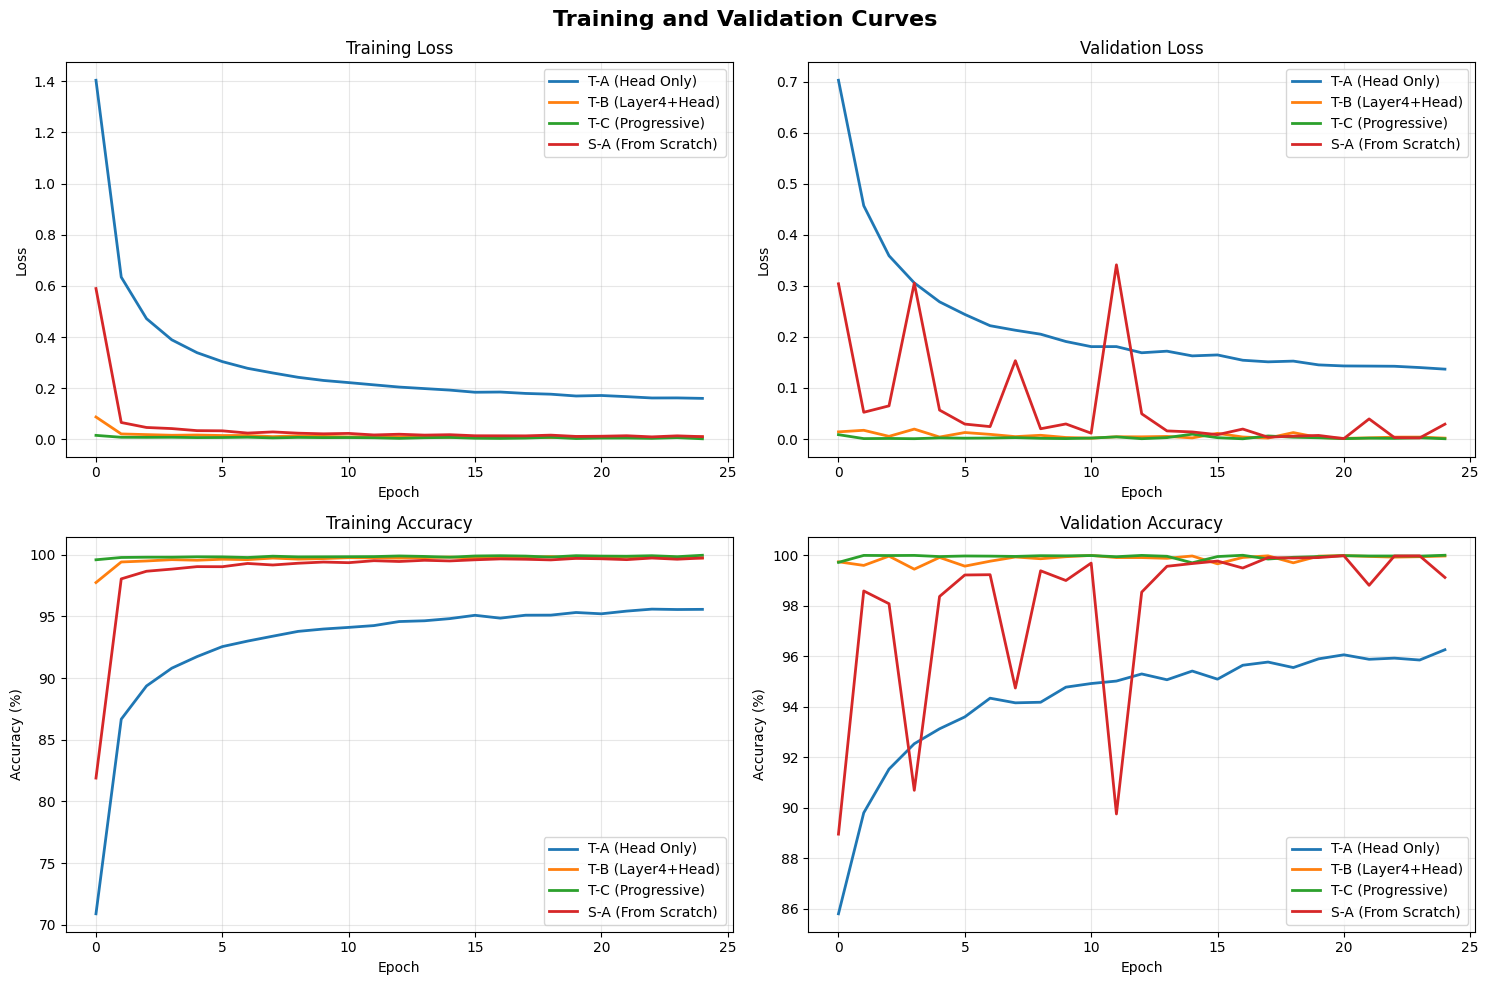

In [19]:
# Plot training curves for all models
plot_training_curves(
    all_histories,
    model_names,
    save_path=FIGS_DIR / 'phase1_training_curves_comparison.png'
)


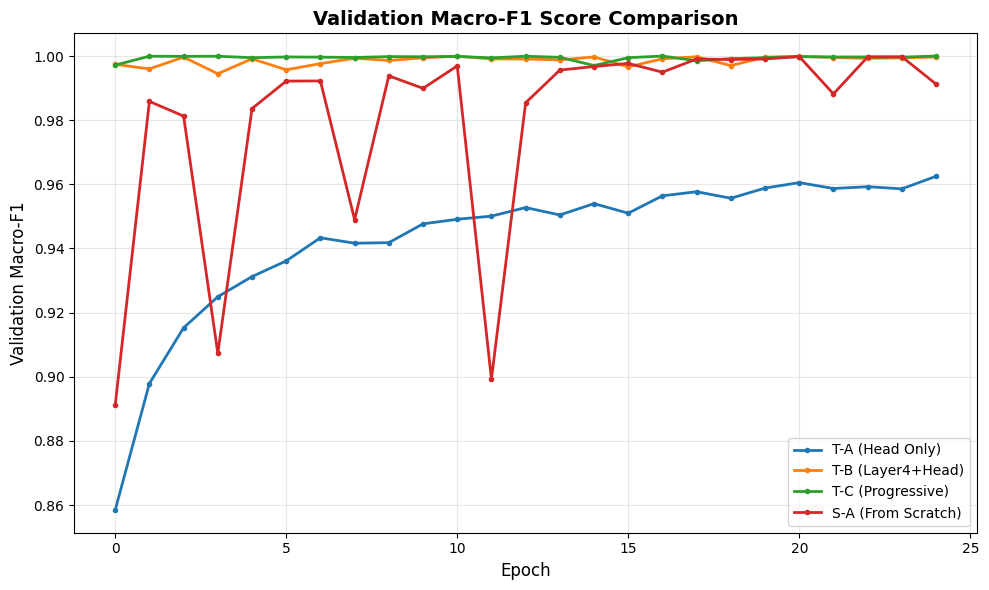

In [20]:
# Plot individual F1 scores over epochs
plt.figure(figsize=(10, 6))
for history, name in zip(all_histories, model_names):
    plt.plot(history['val_f1'], label=name, linewidth=2, marker='o', markersize=3)

plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Validation Macro-F1', fontsize=12)
plt.title('Validation Macro-F1 Score Comparison', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(FIGS_DIR / 'phase1_val_f1_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


 ## 11. Best Model Evaluation on Validation Set

In [21]:
print("\n" + "="*80)
print(f"DETAILED EVALUATION OF BEST MODEL: {best_model_name}")
print("="*80)

# Load best model based on selection
best_models = [
    (model_ta, best_model_ta, 'T-A'),
    (model_tb, best_model_tb, 'T-B'),
    (model_tc, best_model_tc, 'T-C'),
    (model_sa, best_model_sa, 'S-A')
]

selected_model, selected_weights, selected_name = best_models[best_idx]
selected_model.load_state_dict(selected_weights)
selected_model.eval()

# Evaluate on validation set
val_loss, val_acc, val_f1, val_preds, val_labels = evaluate(
    selected_model, val_loader, criterion, device
)

print(f"\nValidation Set Metrics:")
print(f"  Accuracy: {val_acc:.2f}%")
print(f"  Macro-F1: {val_f1:.4f}")
print(f"  Loss: {val_loss:.4f}")

# Classification report
class_names = full_train_dataset.classes
print(f"\nDetailed Classification Report:")
print(classification_report(val_labels, val_preds, target_names=class_names, digits=3))



DETAILED EVALUATION OF BEST MODEL: T-C (Progressive)

Validation Set Metrics:
  Accuracy: 100.00%
  Macro-F1: 1.0000
  Loss: 0.0004

Detailed Classification Report:
              precision    recall  f1-score   support

           A      1.000     1.000     1.000       600
           B      1.000     1.000     1.000       600
           C      1.000     1.000     1.000       600
           D      1.000     1.000     1.000       600
           E      1.000     1.000     1.000       600
           F      1.000     1.000     1.000       600
           G      1.000     1.000     1.000       600
           H      1.000     1.000     1.000       600
           I      1.000     1.000     1.000       600
           J      1.000     1.000     1.000       600
           K      1.000     1.000     1.000       600
           L      1.000     1.000     1.000       600
           M      1.000     1.000     1.000       600
           N      1.000     1.000     1.000       600
           O      1.000

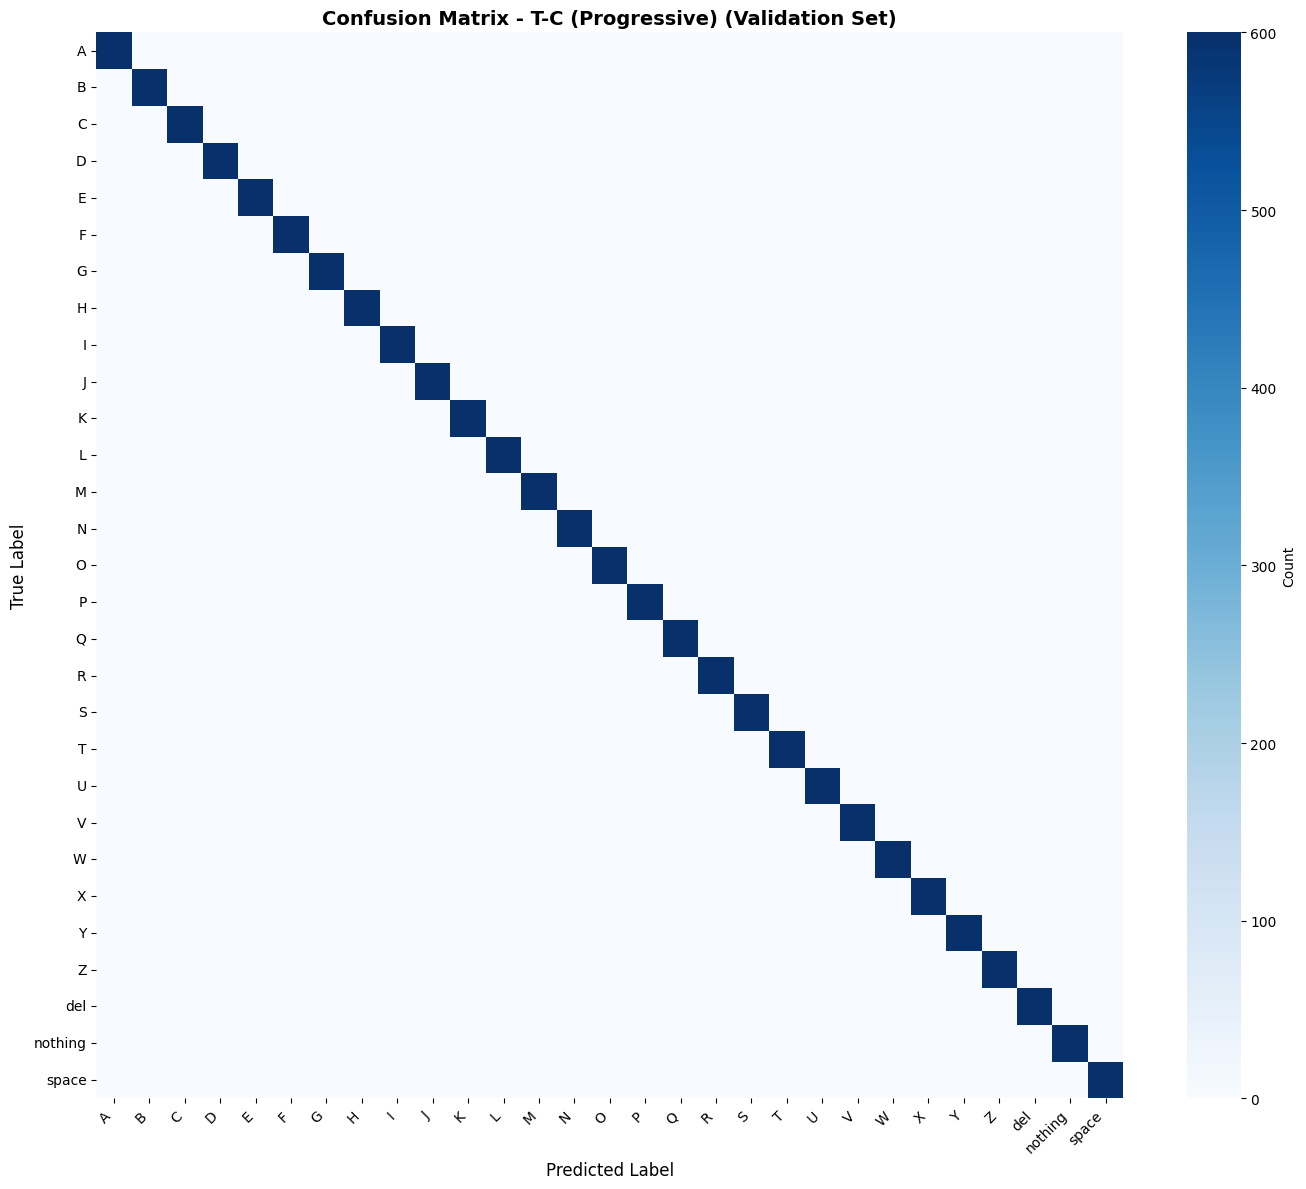

In [22]:
# Plot confusion matrix for best model on validation set
plot_confusion_matrix(
    val_labels, val_preds, class_names,
    title=f'Confusion Matrix - {best_model_name} (Validation Set)',
    save_path=FIGS_DIR / f'phase1_confusion_matrix_{selected_name}_validation.png'
)


 ## 12. Test Set Evaluation



 **Note**: To use this section standalone without training, run:

 - Section 1: Setup & Imports

 - Section 2: Configuration

 - Section 3: Data Loading (first cell only - for val_transform, class_names)

 - Section 4: Helper Functions (last cell with plot_confusion_matrix)

 Then skip to this section.



 Or run all sections 1-11 to train models first.

In [23]:
# Load the best model checkpoint (T-C Progressive)
print("Loading best model from checkpoint...")
checkpoint_path = CHECKPOINT_DIR / "T-C_best.pth"

# Load class names
if 'class_names' not in locals():
    full_train_dataset = datasets.ImageFolder(root=str(TRAIN_DIR))
    class_names = full_train_dataset.classes
    print(f"Loaded {len(class_names)} class names")

# Load model
selected_model = models.resnet18(weights=None)
selected_model.fc = nn.Linear(selected_model.fc.in_features, CONFIG['num_classes'])
selected_model.load_state_dict(torch.load(checkpoint_path, map_location=device))
selected_model = selected_model.to(device)
selected_model.eval()

selected_name = "T-C"
print(f"Model loaded from: {checkpoint_path}")


Loading best model from checkpoint...
Model loaded from: C:\Users\robin\OneDrive\Documents\code\daen429-project\checkpoints\T-C_best.pth


In [24]:
# Evaluate on original test set (28 images: A_test.jpg, B_test.jpg, ...)
from PIL import Image

test_images = sorted(TEST_DIR.glob("*_test.jpg"))
class_to_idx = {name: idx for idx, name in enumerate(class_names)}

print(f"\nEvaluating on {len(test_images)} test images...")

test_preds, test_labels = [], []
selected_model.eval()

with torch.no_grad():
    for img_path in test_images:
        # Extract label from filename (e.g., "A_test.jpg" -> "A")
        label_name = img_path.stem.replace("_test", "")
        true_label = class_to_idx[label_name]

        # Load, transform, and predict
        img = Image.open(img_path).convert('RGB')
        img_tensor = val_transform(img).unsqueeze(0).to(device)
        outputs = selected_model(img_tensor)

        test_preds.append(outputs.argmax(1).item())
        test_labels.append(true_label)

# Calculate metrics
test_acc = accuracy_score(test_labels, test_preds) * 100
test_f1 = f1_score(test_labels, test_preds, average='macro')

# Get actual classes present in test set
test_class_indices = sorted(set(test_labels))
test_class_names = [class_names[i] for i in test_class_indices]

print("\n" + "="*80)
print(f"TEST SET EVALUATION - T-C (Progressive)")
print("="*80)
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Test Macro-F1: {test_f1:.4f}")
print(f"Classes evaluated: {len(test_class_names)}/29")
print("="*80)

# Classification report
print(f"\nTest Set Classification Report:")
print(classification_report(test_labels, test_preds,
                          labels=test_class_indices,
                          target_names=test_class_names, digits=3))



Evaluating on 28 test images...

TEST SET EVALUATION - T-C (Progressive)
Test Accuracy: 100.00%
Test Macro-F1: 1.0000
Classes evaluated: 28/29

Test Set Classification Report:
              precision    recall  f1-score   support

           A      1.000     1.000     1.000         1
           B      1.000     1.000     1.000         1
           C      1.000     1.000     1.000         1
           D      1.000     1.000     1.000         1
           E      1.000     1.000     1.000         1
           F      1.000     1.000     1.000         1
           G      1.000     1.000     1.000         1
           H      1.000     1.000     1.000         1
           I      1.000     1.000     1.000         1
           J      1.000     1.000     1.000         1
           K      1.000     1.000     1.000         1
           L      1.000     1.000     1.000         1
           M      1.000     1.000     1.000         1
           N      1.000     1.000     1.000         1
           O

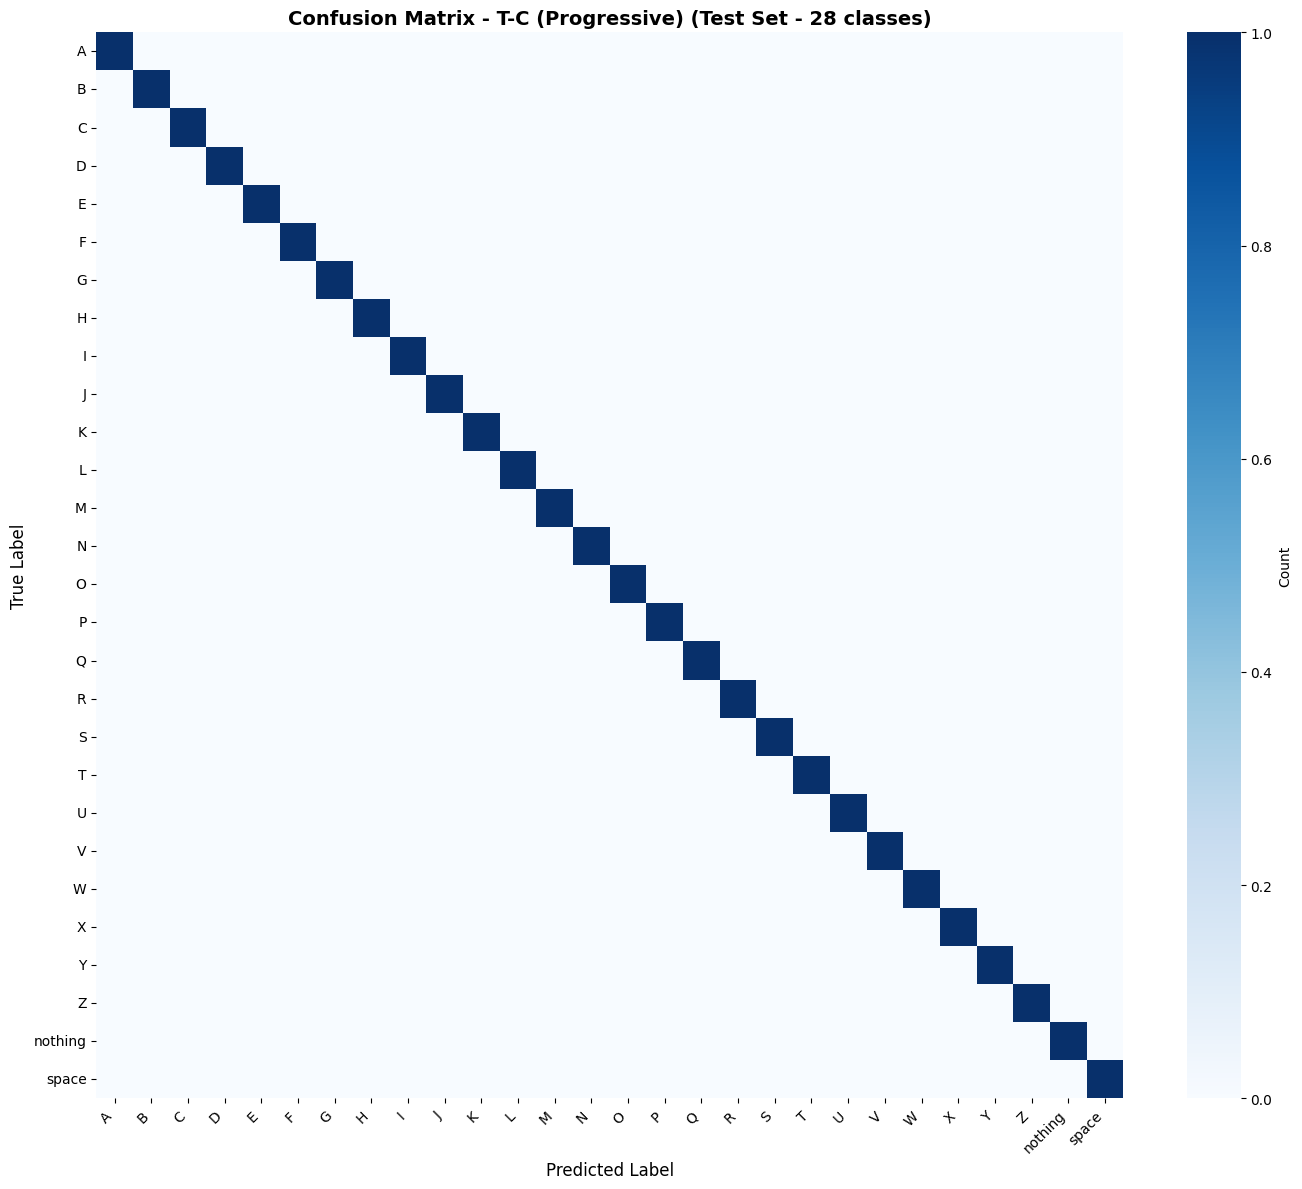

In [25]:
# Confusion matrix for test set
plot_confusion_matrix(
    test_labels, test_preds, test_class_names,
    title=f'Confusion Matrix - T-C (Progressive) (Test Set - {len(test_class_names)} classes)',
    save_path=FIGS_DIR / f'phase1_confusion_matrix_{selected_name}_test.png'
)


 ## 13. Custom Test Set Evaluation



 Evaluates the model on your custom hand-sign photos in `custom_test_set/`


Custom test set: 28 images across 28 classes


C:\Users\robin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
C:\Users\robin\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_pred = type_of_target(y_pred, input_name="y_pred")
C:\Users\robin\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
C:\Users\robin\AppData\Roaming\Python\Python312\site-package


CUSTOM TEST SET EVALUATION - T-C (Progressive)
Accuracy: 75.00%
Macro-F1: 0.6724
Classes evaluated: 28

Per-Class Results:
              precision    recall  f1-score   support

           A      1.000     1.000     1.000         1
           B      1.000     1.000     1.000         1
           C      1.000     1.000     1.000         1
           D      1.000     1.000     1.000         1
           E      0.500     1.000     0.667         1
           F      1.000     1.000     1.000         1
           G      0.000     0.000     0.000         1
           H      0.333     1.000     0.500         1
           I      1.000     1.000     1.000         1
           J      0.000     0.000     0.000         1
           K      1.000     1.000     1.000         1
           L      1.000     1.000     1.000         1
           M      0.000     0.000     0.000         1
           N      0.500     1.000     0.667         1
           O      1.000     1.000     1.000         1
           

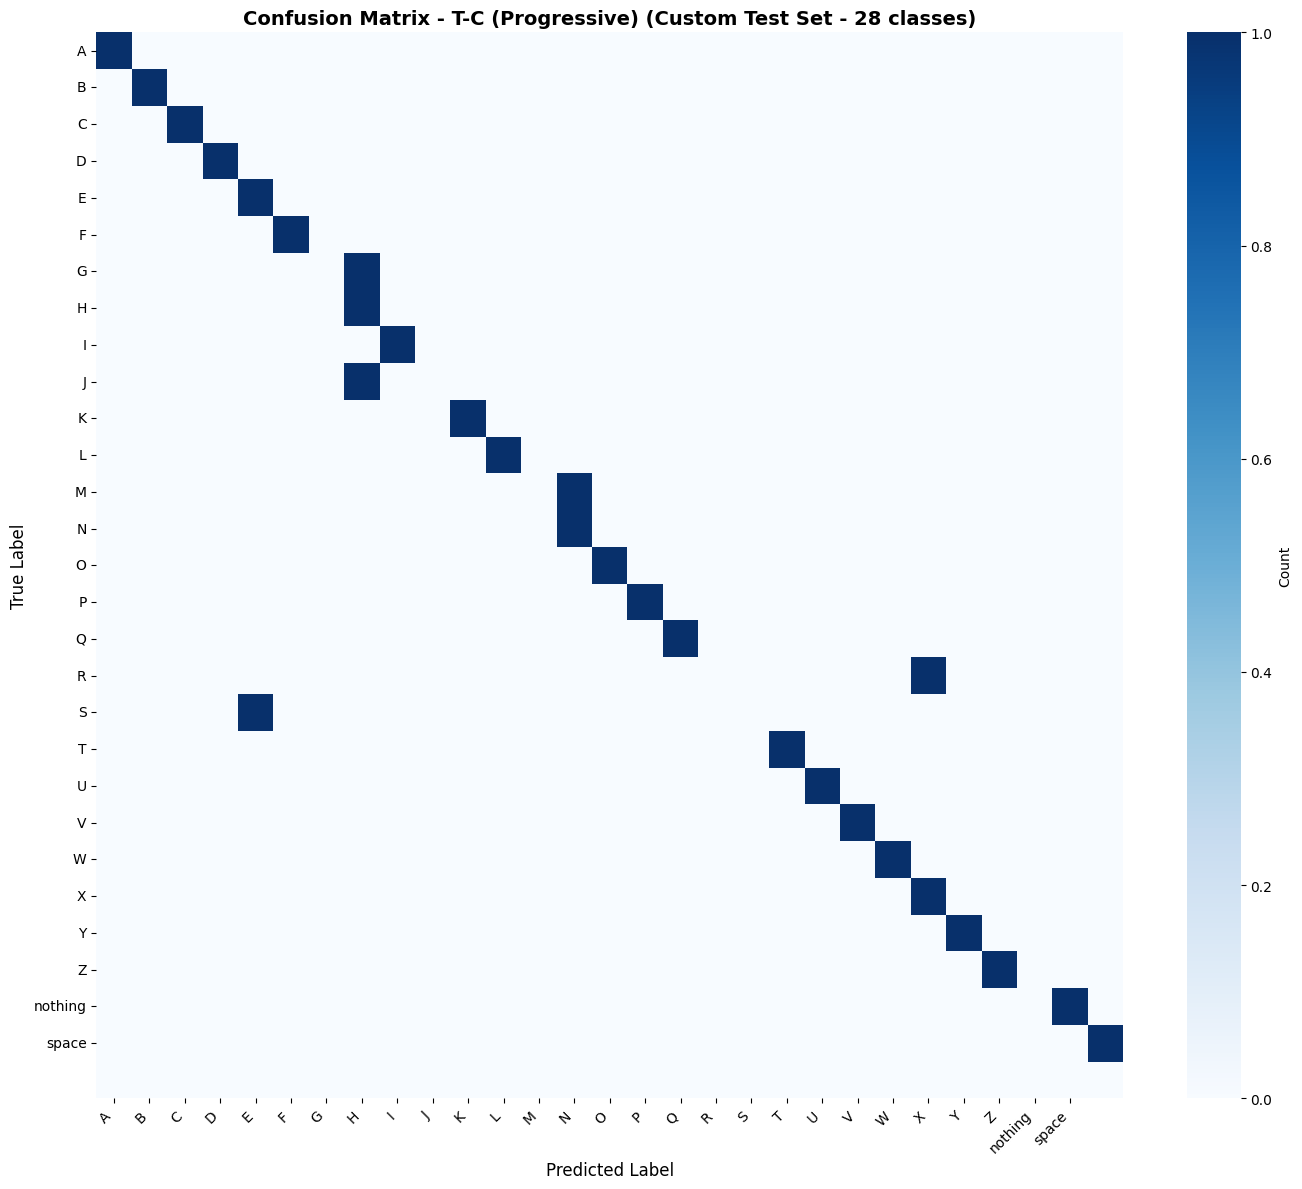

In [26]:
# Evaluate on custom test set (20+ new hand-sign images)
CUSTOM_TEST_DIR = DATA_ROOT / "custom_test_set"

if CUSTOM_TEST_DIR.exists():
    custom_dataset = datasets.ImageFolder(root=str(CUSTOM_TEST_DIR), transform=val_transform)
    custom_loader = DataLoader(custom_dataset, batch_size=32, shuffle=False,
                               num_workers=CONFIG['num_workers'])

    print(f"\nCustom test set: {len(custom_dataset)} images across {len(custom_dataset.classes)} classes")

    # Evaluate
    custom_preds, custom_labels = [], []
    selected_model.eval()

    with torch.no_grad():
        for inputs, labels in custom_loader:
            outputs = selected_model(inputs.to(device))
            custom_preds.extend(outputs.argmax(1).cpu().numpy())
            custom_labels.extend(labels.numpy())

    custom_acc = accuracy_score(custom_labels, custom_preds) * 100
    custom_f1 = f1_score(custom_labels, custom_preds, average='macro')

    # Get actual classes present in custom test set
    custom_class_indices = sorted(set(custom_labels))
    custom_class_names = [custom_dataset.classes[i] for i in custom_class_indices]

    # Results
    print("\n" + "="*80)
    print("CUSTOM TEST SET EVALUATION - T-C (Progressive)")
    print("="*80)
    print(f"Accuracy: {custom_acc:.2f}%")
    print(f"Macro-F1: {custom_f1:.4f}")
    print(f"Classes evaluated: {len(custom_class_names)}")
    print("="*80)

    print(f"\nPer-Class Results:")
    print(classification_report(custom_labels, custom_preds,
                                labels=custom_class_indices,
                                target_names=custom_class_names, digits=3))

    # Confusion matrix
    plot_confusion_matrix(
        custom_labels, custom_preds, custom_class_names,
        title=f'Confusion Matrix - T-C (Progressive) (Custom Test Set - {len(custom_class_names)} classes)',
        save_path=FIGS_DIR / f'phase1_confusion_matrix_{selected_name}_custom.png'
    )
else:
    print(f"\nCustom test set not found at {CUSTOM_TEST_DIR}")


 ## 14. Summary



 **Full experiment summary** (requires running sections 1-11)

In [27]:
if 'results_summary' in locals() and 'best_idx' in locals():
    # Complete training results available
    print("\n" + "="*80)
    print("PHASE 1 ABLATION STUDY RESULTS")
    print("="*80)
    print("\nValidation Set Performance:")
    for result in results_summary:
        print(f"  {result['Model']:<25} F1: {result['Best Val F1']:.4f}  "
              f"Acc: {result['Best Val Acc (%)']:.2f}%  Epoch: {result['Epoch']}")

    print(f"\nBest Model: {best_model_name}")
    print(f"  • Validation F1: {results_summary[best_idx]['Best Val F1']:.4f}")
    print(f"  • Test Set Accuracy: {test_acc:.2f}%, F1: {test_f1:.4f}")
    if 'custom_acc' in locals():
        print(f"  • Custom Test Accuracy: {custom_acc:.2f}%, F1: {custom_f1:.4f}")

    print("\nSaved outputs:")
    print(f"  • Checkpoints: {CHECKPOINT_DIR}")
    print(f"  • Figures: {FIGS_DIR}")
    print("="*80)
else:
    # Evaluation-only mode
    print("\n" + "="*80)
    print("EVALUATION RESULTS")
    print("="*80)
    print(f"Model: T-C (Progressive)")
    print(f"  • Test Set: {test_acc:.2f}% accuracy, {test_f1:.4f} F1")
    if 'custom_acc' in locals():
        print(f"  • Custom Test: {custom_acc:.2f}% accuracy, {custom_f1:.4f} F1")
    print("="*80)





PHASE 1 ABLATION STUDY RESULTS

Validation Set Performance:
  T-A (Head Only)           F1: 0.9625  Acc: 96.26%  Epoch: 25
  T-B (Layer4+Head)         F1: 0.9999  Acc: 99.99%  Epoch: 11
  T-C (Progressive)         F1: 1.0000  Acc: 100.00%  Epoch: 17
  S-A (From Scratch)        F1: 0.9998  Acc: 99.98%  Epoch: 21

Best Model: T-C (Progressive)
  • Validation F1: 1.0000
  • Test Set Accuracy: 100.00%, F1: 1.0000
  • Custom Test Accuracy: 75.00%, F1: 0.6724

Saved outputs:
  • Checkpoints: C:\Users\robin\OneDrive\Documents\code\daen429-project\checkpoints
  • Figures: C:\Users\robin\OneDrive\Documents\code\daen429-project\figs
